0:	learn: 982.0219968	test: 985.0715570	best: 985.0715570 (0)	total: 47.9ms	remaining: 23.9s
50:	learn: 343.4690221	test: 339.0761114	best: 339.0761114 (50)	total: 2.28s	remaining: 20.1s
100:	learn: 248.4326002	test: 240.8736705	best: 240.8736705 (100)	total: 4.56s	remaining: 18s
150:	learn: 210.6196122	test: 205.2831225	best: 205.2831225 (150)	total: 6.74s	remaining: 15.6s
200:	learn: 183.9989085	test: 181.7434157	best: 181.7434157 (200)	total: 8.96s	remaining: 13.3s
250:	learn: 166.4382560	test: 169.6835314	best: 169.6835314 (250)	total: 11s	remaining: 10.9s
300:	learn: 149.0274975	test: 158.3275008	best: 158.3275008 (300)	total: 12.9s	remaining: 8.52s
350:	learn: 135.9579312	test: 151.1416608	best: 151.1416608 (350)	total: 14.8s	remaining: 6.3s
400:	learn: 126.8337363	test: 147.2142364	best: 147.2142364 (400)	total: 16.8s	remaining: 4.14s
450:	learn: 117.9021919	test: 142.6310692	best: 142.6310692 (450)	total: 18.9s	remaining: 2.05s
499:	learn: 111.5760334	test: 139.9639401	best: 13

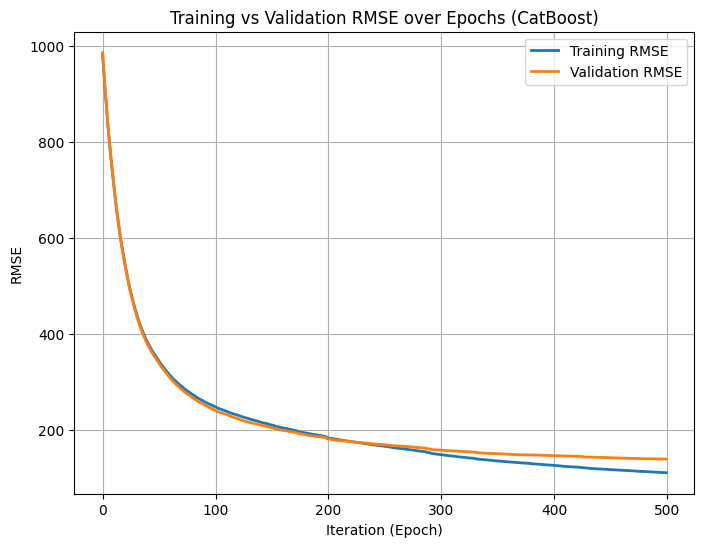


MODEL PERFORMANCE METRICS
MAE:  96.445
RMSE: 139.964
R²:   0.981


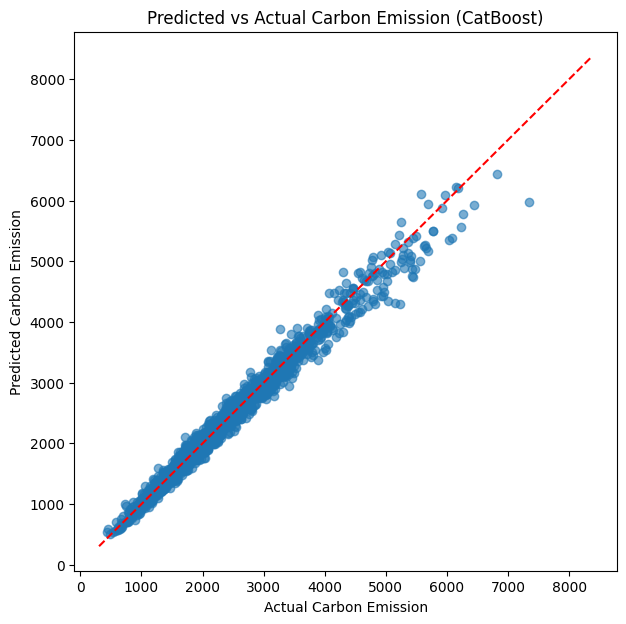

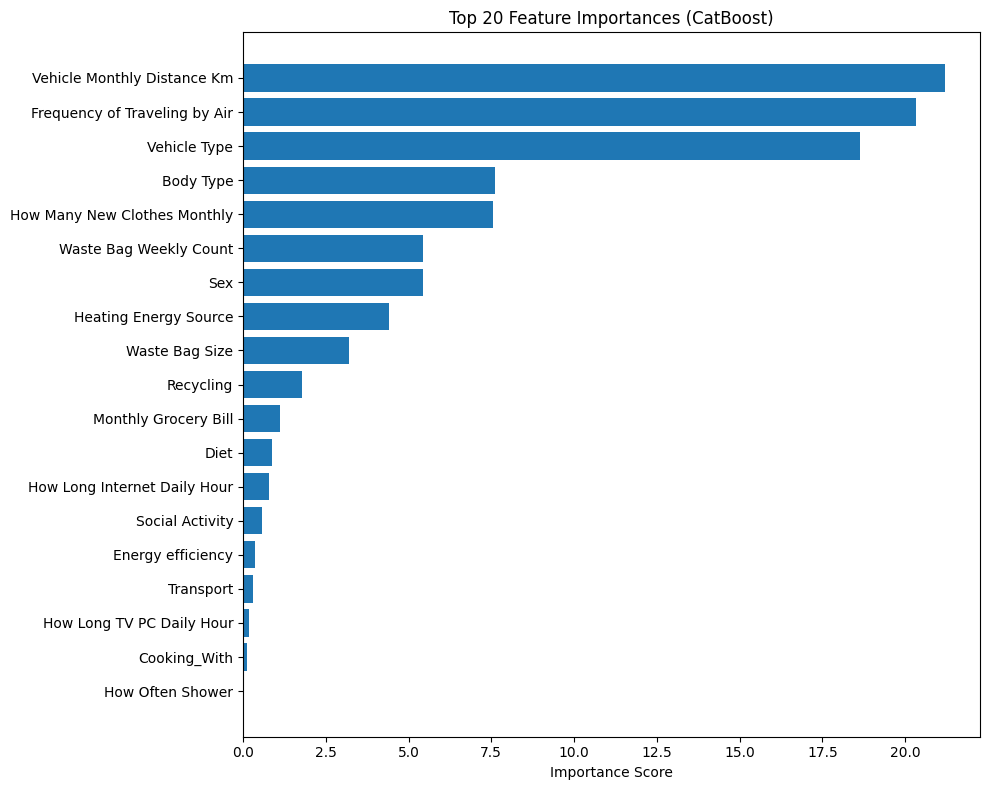


Best iteration (epoch): 499
Best validation RMSE: 139.964
Model saved as carbon_catboost_model.cbm


In [6]:
# ============================================
#  CARBON EMISSION MODEL - CATBOOST VERSION
#     (with training history saving)
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor, Pool

# ----------------------------
# 1. LOAD DATA
# ----------------------------
df = pd.read_csv(r"C:\Users\Admin\Desktop\Honours_LY\Carbon Emission.csv")
df.columns = df.columns.str.strip()  # clean spaces in column names

# --- FIX: handle NaNs and types properly ---
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna("Unknown").astype(str)

for col in df.select_dtypes(exclude=['object']).columns:
    df[col] = df[col].fillna(df[col].median())
# -------------------------------------------

target = 'CarbonEmission'
X = df.drop(columns=[target])
y = df[target]

# Identify categorical columns (CatBoost needs column indices)
cat_features = X.select_dtypes(include=['object']).columns.tolist()
cat_feature_indices = [X.columns.get_loc(col) for col in cat_features]

# ----------------------------
# 2. TRAIN / TEST SPLIT
# ----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Create CatBoost Pool datasets
train_pool = Pool(X_train, y_train, cat_features=cat_feature_indices)
test_pool = Pool(X_test, y_test, cat_features=cat_feature_indices)

# ----------------------------
# 3. DEFINE MODEL
# ----------------------------
model = CatBoostRegressor(
    iterations=500,          
    learning_rate=0.05,
    depth=8,
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    early_stopping_rounds=30,
    verbose=50
)

# ----------------------------
# 4. TRAIN MODEL
# ----------------------------
model.fit(train_pool, eval_set=test_pool, use_best_model=True, verbose=50)

# ----------------------------
# 5. EXTRACT & SAVE TRAINING HISTORY
# ----------------------------
eval_history = model.get_evals_result()

train_rmse = eval_history['learn']['RMSE']
val_rmse = eval_history['validation']['RMSE']

# --- Save JSON ---
with open("catboost_training_history.json", "w") as f:
    json.dump(eval_history, f, indent=4)

# --- Save as CSV ---
history_df = pd.DataFrame({
    "iteration": range(len(train_rmse)),
    "train_rmse": train_rmse,
    "validation_rmse": val_rmse
})
history_df.to_csv("catboost_training_history.csv", index=False)

print("\nTraining history saved as JSON and CSV.")

# ----------------------------
# 6. PLOT TRAINING vs VALIDATION RMSE
# ----------------------------
plt.figure(figsize=(8,6))
plt.plot(train_rmse, label='Training RMSE', linewidth=2)
plt.plot(val_rmse, label='Validation RMSE', linewidth=2)
plt.xlabel("Iteration (Epoch)")
plt.ylabel("RMSE")
plt.title("Training vs Validation RMSE over Epochs (CatBoost)")
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------
# 7. EVALUATE PERFORMANCE
# ----------------------------
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\nMODEL PERFORMANCE METRICS")
print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²:   {r2:.3f}")

# ----------------------------
# 8. PREDICTED vs ACTUAL PLOT
# ----------------------------
plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Carbon Emission")
plt.ylabel("Predicted Carbon Emission")
plt.title("Predicted vs Actual Carbon Emission (CatBoost)")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.show()

# ----------------------------
# 9. FEATURE IMPORTANCE
# ----------------------------
feature_importances = model.get_feature_importance(train_pool)
sorted_idx = np.argsort(feature_importances)[-20:]  # top 20

plt.figure(figsize=(10,8))
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx])
plt.yticks(range(len(sorted_idx)), [X.columns[i] for i in sorted_idx])
plt.title("Top 20 Feature Importances (CatBoost)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# ----------------------------
# 10. BEST ITERATION
# ----------------------------
print(f"\nBest iteration (epoch): {model.get_best_iteration()}")
print(f"Best validation RMSE: {model.get_best_score()['validation']['RMSE']:.3f}")

model.save_model("carbon_catboost_model.cbm")
print("Model saved as carbon_catboost_model.cbm")

In [11]:
import pandas as pd
from catboost import CatBoostRegressor

# -----------------------------------------
# 1. LOAD TRAINED CATBOOST MODEL
# -----------------------------------------
model = CatBoostRegressor()
model.load_model("carbon_catboost_model.cbm")   # <-- ensure this file exists

print("Model loaded successfully.\n")

# -----------------------------------------
# 2. CREATE RANDOM REAL-TIME SAMPLE INPUT
# -----------------------------------------
sample = {
    "Body Type": "Medium",
    "Sex": "Male",
    "Diet": "Mixed",
    "How Often Shower": 1,
    "Heating Energy Source": "Natural Gas",
    "Transport": "Car",
    "Vehicle Type": "Sedan",
    "Social Activity": 3,
    "Monthly Grocery Bill": 450,
    "Frequency of Traveling by Air": 1,
    "Vehicle Monthly Distance Km": 600,
    "Waste Bag Size": "Medium",
    "Waste Bag Weekly Count": 2,
    "How Long TV PC Daily Hour": 4,
    "How Many New Clothes Monthly": 3,
    "How Long Internet Daily Hour": 6,
    "Energy efficiency": "Yes",
    "Recycling": "Sometimes",
    "Cooking_With": "Electric"
}

df_new = pd.DataFrame([sample])

# -----------------------------------------
# 3. PREPROCESS (same logic used during training)
# -----------------------------------------
for col in df_new.select_dtypes(include=['object']).columns:
    df_new[col] = df_new[col].fillna("Unknown").astype(str)

for col in df_new.select_dtypes(exclude=['object']).columns:
    df_new[col] = df_new[col].fillna(df_new[col].median())

# -----------------------------------------
# 4. REAL-TIME CARBON EMISSION PREDICTION
# -----------------------------------------
prediction = model.predict(df_new)

print("INPUT SAMPLE:")
print(df_new)
print("\nPredicted Carbon Emission:", prediction[0])


Model loaded successfully.

INPUT SAMPLE:
  Body Type   Sex   Diet  How Often Shower Heating Energy Source Transport  \
0    Medium  Male  Mixed                 1           Natural Gas       Car   

  Vehicle Type  Social Activity  Monthly Grocery Bill  \
0        Sedan                3                   450   

   Frequency of Traveling by Air  Vehicle Monthly Distance Km Waste Bag Size  \
0                              1                          600         Medium   

   Waste Bag Weekly Count  How Long TV PC Daily Hour  \
0                       2                          4   

   How Many New Clothes Monthly  How Long Internet Daily Hour  \
0                             3                             6   

  Energy efficiency  Recycling Cooking_With  
0               Yes  Sometimes     Electric  

Predicted Carbon Emission: 1607.890195689571


In [12]:
import pandas as pd
from catboost import CatBoostRegressor

# =====================================================
# 1. LOAD ALL 3 MODELS (Main + Low Quantile + High Quantile)
# =====================================================
main_model = CatBoostRegressor()
main_model.load_model("carbon_catboost_model.cbm")

low_model = CatBoostRegressor()
low_model.load_model("carbon_model_low.cbm")  # 10% quantile model

high_model = CatBoostRegressor()
high_model.load_model("carbon_model_high.cbm")  # 90% quantile model

print("All models loaded successfully.\n")

# =====================================================
# 2. REAL-TIME SAMPLE INPUT
# =====================================================
sample = {
    "Body Type": "Medium",
    "Sex": "Male",
    "Diet": "Mixed",
    "How Often Shower": 1,
    "Heating Energy Source": "Natural Gas",
    "Transport": "Car",
    "Vehicle Type": "Sedan",
    "Social Activity": 3,
    "Monthly Grocery Bill": 450,
    "Frequency of Traveling by Air": 1,
    "Vehicle Monthly Distance Km": 600,
    "Waste Bag Size": "Medium",
    "Waste Bag Weekly Count": 2,
    "How Long TV PC Daily Hour": 4,
    "How Many New Clothes Monthly": 3,
    "How Long Internet Daily Hour": 6,
    "Energy efficiency": "Yes",
    "Recycling": "Sometimes",
    "Cooking_With": "Electric"
}

df_new = pd.DataFrame([sample])

# =====================================================
# 3. PREPROCESS INPUT (must match training preprocessing)
# =====================================================
for col in df_new.select_dtypes(include=['object']).columns:
    df_new[col] = df_new[col].fillna("Unknown").astype(str)

for col in df_new.select_dtypes(exclude=['object']).columns:
    df_new[col] = df_new[col].fillna(df_new[col].median())

# =====================================================
# 4. PREDICT WITH CONFIDENCE INTERVAL
# =====================================================
pred_mean = main_model.predict(df_new)[0]      # main prediction
pred_low = low_model.predict(df_new)[0]        # lower confidence bound
pred_high = high_model.predict(df_new)[0]      # upper confidence bound

# =====================================================
# 5. PRINT RESULTS
# =====================================================
print("INPUT SAMPLE:")
print(df_new)

print("\nPredicted Carbon Emission:", round(pred_mean, 3))
print("Confidence Interval (10%–90%): [{:.3f}, {:.3f}]".format(pred_low, pred_high))
print("Uncertainty Range:", round(pred_high - pred_low, 3))


CatBoostError: catboost/libs/model/model_import_interface.h:19: Model file doesn't exist: carbon_model_low.cbm